In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model, tree
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
 
from sklearn.metrics import roc_curve, confusion_matrix,precision_recall_curve,roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 

import xgboost as xgb # note for installation use py-xgboost in conda

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
plt.style.use('seaborn')
np.random.seed(42)

In [2]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
test['target'] = -999
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

train['dataset'] = 'train'
test['dataset'] = 'test'

X = pd.concat([train,test],sort=True)

In [9]:
num_features = list(X.columns[X.dtypes!=object])
num_features.remove('target')
cat_features = list(X.columns[X.dtypes==object])

In [49]:
cols = pd.read_csv('HomeCredit_columns_description.csv', encoding= 'unicode_escape')
column_description = cols[cols.Table == 'application_{train|test}.csv']
column_description.columns = column_description.columns.str.lower()
column_description.drop(['unnamed: 0', 'table'], axis=1, inplace=True)
column_description['row'] = column_description['row'].apply(lambda x: x.lower())
column_description.head(2)

/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,row,description,special
0,sk_id_curr,ID of loan in our sample,NaN
1,target,Target variable (1 - client with payment diffi...,NaN


In [50]:
special_col = column_description.special.unique()

In [51]:
column_description[column_description.special == special_col[2]]

,row,description,special
17,days_birth,Client's age in days at the time of application,time only relative to the application
18,days_employed,How many days before the application the perso...,time only relative to the application
19,days_registration,How many days before the application did clien...,time only relative to the application
20,days_id_publish,How many days before the application did clien...,time only relative to the application


In [52]:
column_description[column_description.special == special_col[1]]

,row,description,special
16,region_population_relative,Normalized population of region where client l...,normalized


In [53]:
column_description[column_description.special == special_col[3]]

,row,description,special
33,hour_appr_process_start,Approximately at what hour did the client appl...,rounded


In [54]:
column_description[column_description.special == special_col[4]].head()

,row,description,special
41,ext_source_1,Normalized score from external data source,normalized
42,ext_source_2,Normalized score from external data source,normalized
43,ext_source_3,Normalized score from external data source,normalized
44,apartments_avg,Normalized information about building where th...,normalized
45,basementarea_avg,Normalized information about building where th...,normalized


In [58]:
def get_col_descr(feature):
    return column_description[column_description.row == feature].loc[:, 'description'].tolist()

In [59]:
get_col_descr('days_birth')

["Client's age in days at the time of application"]

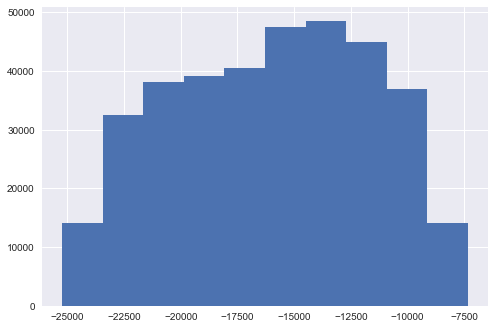

In [60]:
X.days_birth.hist()

In [61]:
X.days_birth.describe()

count    356255.000000
mean     -16041.248841
std        4358.803980
min      -25229.000000
25%      -19676.000000
50%      -15755.000000
75%      -12425.000000
max       -7338.000000
Name: days_birth, dtype: float64

In [70]:
print('oldest: ' + str(int(X.days_birth.min() / -365)))
print('youngest: ' + str(int(X.days_birth.max() / -365)))

oldest: 69
youngest: 20


In [74]:
X['age'] = X['days_birth'].apply(lambda x: int(x / -365))

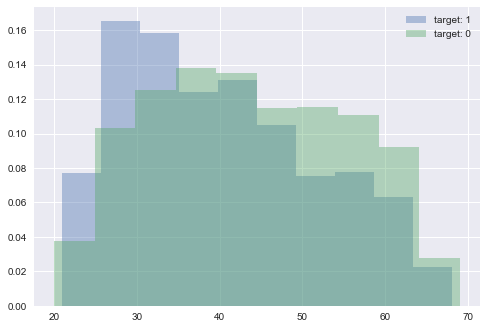

In [150]:
plt1 = X[(X.dataset == 'train') & (X.target == 1)].age
plt0 = X[(X.dataset == 'train') & (X.target == 0)].age
hist_print(plt1, plt0)

In [149]:
def hist_print(data1, data0):
    plt.hist(data1, alpha=0.4, label='target: 1', bins=10, weights=np.ones(len(data1)) / len(data1))
    plt.hist(data0, alpha=0.4, label='target: 0', bins=10, weights=np.ones(len(data0)) / len(data0))
    plt.legend(loc='best')
    plt.show()

In [91]:
get_col_descr('days_employed')

['How many days before the application the person started current employment']

In [85]:
X.days_employed.describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: days_employed, dtype: float64

In [86]:
print('oldest: ' + str(int(X.days_employed.min() / -365)))
print('youngest: ' + str(int(X.days_employed.max() / -365)))

oldest: 49
youngest: -1000


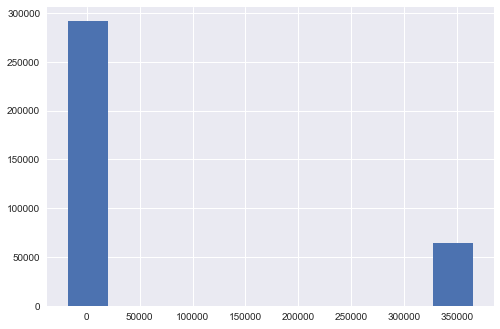

In [87]:
X.days_employed.hist()

In [94]:
X['employed'] = X['days_employed'].apply(lambda x: int(x / -365))

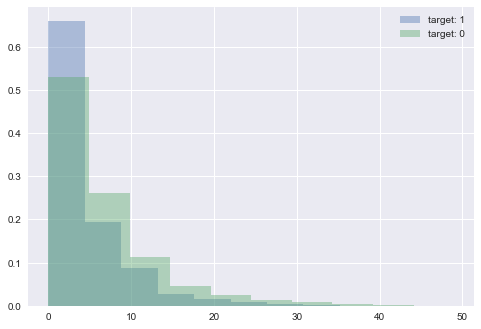

In [153]:
plt0 = X[(X.dataset == 'train') & (X.employed > -1) & (X.target == 0)].employed
plt1 = X[(X.dataset == 'train') & (X.employed > -1) & (X.target == 1)].employed
hist_print(plt1, plt0)

In [101]:
get_col_descr('days_registration')

['How many days before the application did client change his registration']

In [102]:
X.days_registration.describe()

count    356255.000000
mean      -4983.593527
std        3526.968986
min      -24672.000000
25%       -7477.000000
50%       -4502.000000
75%       -1995.000000
max           0.000000
Name: days_registration, dtype: float64

In [112]:
print('longest: ' + str(int(X.days_registration.min() / -365)))
print('shortest: ' + str(int(X.days_registration.max() / -365)))

longest: 67
shortest: 0


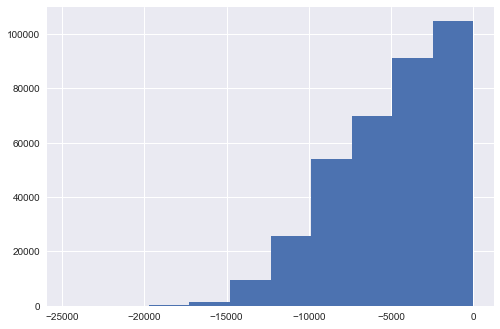

In [114]:
X.days_registration.hist()

In [116]:
X['reg_changed'] = X['days_registration'].apply(lambda x: int(x / -365))

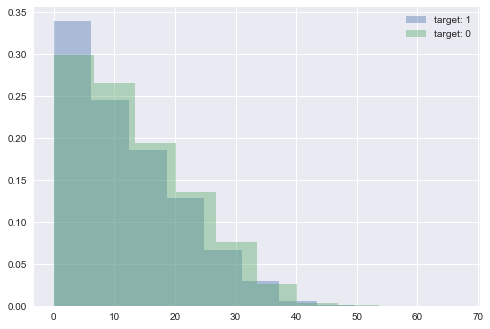

In [154]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].reg_changed
plt1 = X[(X.dataset == 'train') & (X.target == 1)].reg_changed
hist_print(plt1, plt0)

In [104]:
get_col_descr('days_id_publish')

['How many days before the application did client change the identity document with which he applied for the loan']

In [105]:
X.days_id_publish.describe()

count    356255.000000
mean      -3002.071163
std        1517.901735
min       -7197.000000
25%       -4318.000000
50%       -3252.000000
75%       -1717.000000
max           0.000000
Name: days_id_publish, dtype: float64

In [106]:
print('longest: ' + str(int(X.days_id_publish.min() / -365)))
print('shortest: ' + str(int(X.days_id_publish.max() / -365)))

longest: 19
shortest: 0


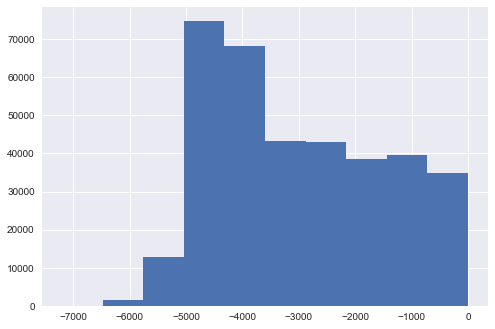

In [107]:
X.days_id_publish.hist()

In [108]:
X['id_changed'] = X['days_id_publish'].apply(lambda x: int(x / -365))

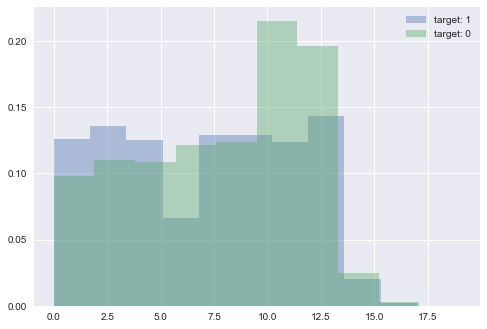

In [155]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].id_changed
plt1 = X[(X.dataset == 'train') & (X.target == 1)].id_changed
hist_print(plt1, plt0)

In [121]:
get_col_descr('region_population_relative')

['Normalized population of region where client lives (higher number means the client lives in more populated region)']

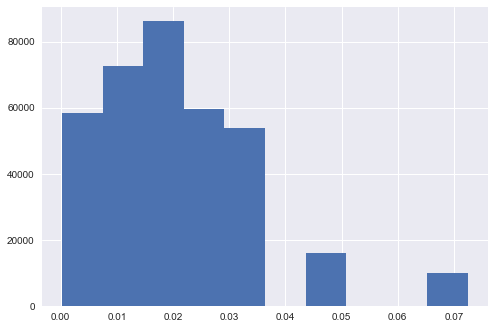

In [122]:
X.region_population_relative.hist()

In [123]:
X.region_population_relative.describe()

count    356255.000000
mean          0.020917
std           0.013915
min           0.000253
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: region_population_relative, dtype: float64

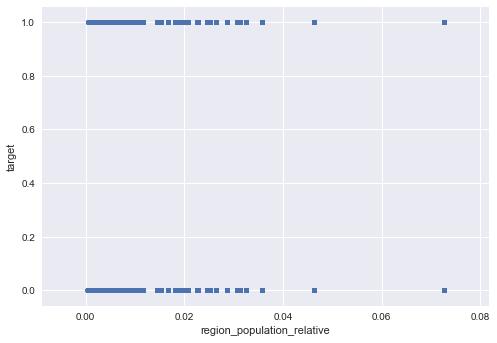

In [125]:
train.plot(kind='scatter', x='region_population_relative', y='target')

In [126]:
get_col_descr('hour_appr_process_start')

['Approximately at what hour did the client apply for the loan']

In [127]:
X.hour_appr_process_start.describe()

count    356255.000000
mean         12.055749
std           3.267576
min           0.000000
25%          10.000000
50%          12.000000
75%          14.000000
max          23.000000
Name: hour_appr_process_start, dtype: float64

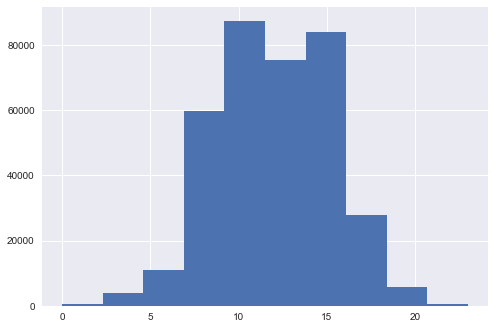

In [128]:
X.hour_appr_process_start.hist()

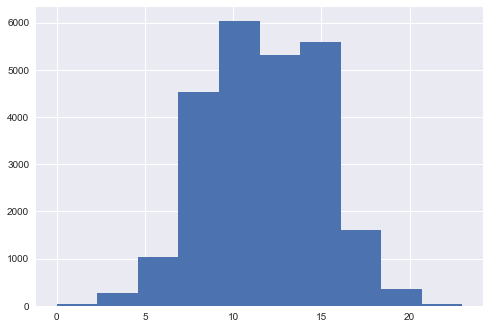

In [129]:
X[(X.dataset == 'train') & (X.target == 1)].hour_appr_process_start.hist()

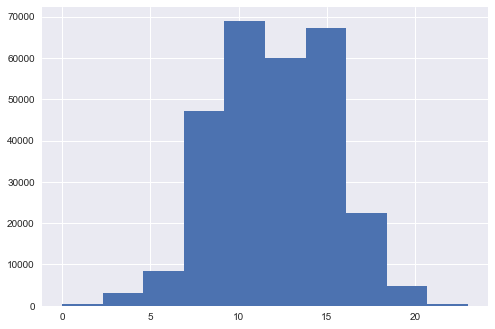

In [130]:
X[(X.dataset == 'train') & (X.target == 0)].hour_appr_process_start.hist()

In [160]:
column_description[column_description.special == special_col[4]].head()

,row,description,special
41,ext_source_1,Normalized score from external data source,normalized
42,ext_source_2,Normalized score from external data source,normalized
43,ext_source_3,Normalized score from external data source,normalized
44,apartments_avg,Normalized information about building where th...,normalized
45,basementarea_avg,Normalized information about building where th...,normalized


In [161]:
get_col_descr('ext_source_1')

['Normalized score from external data source']

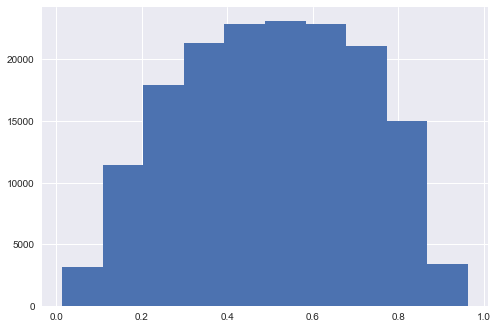

In [159]:
X.ext_source_1.hist()

/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/lib/histograms.py:834: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/lib/histograms.py:835: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


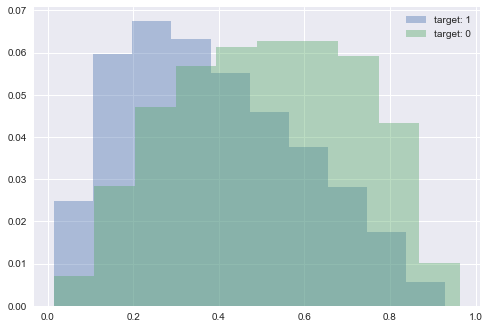

In [162]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].ext_source_1
plt1 = X[(X.dataset == 'train') & (X.target == 1)].ext_source_1
hist_print(plt1, plt0)

In [163]:
get_col_descr('ext_source_2')

['Normalized score from external data source']

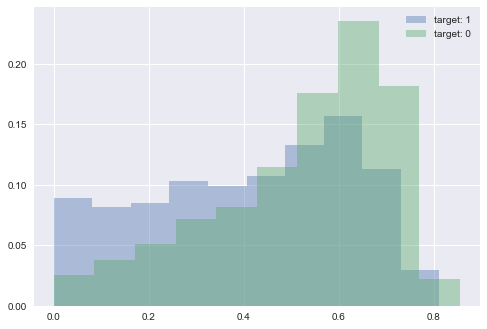

In [165]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].ext_source_2
plt1 = X[(X.dataset == 'train') & (X.target == 1)].ext_source_2
hist_print(plt1, plt0)

In [166]:
get_col_descr('ext_source_3')

['Normalized score from external data source']

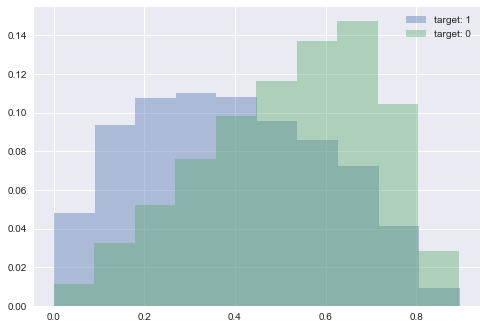

In [167]:
plt0 = X[(X.dataset == 'train') & (X.target == 0)].ext_source_3
plt1 = X[(X.dataset == 'train') & (X.target == 1)].ext_source_3
hist_print(plt1, plt0)